In [ ]:
! pip3 -q install optax

     |████████████████████████████████| 140 kB 5.3 MB/s 
     |████████████████████████████████| 72 kB 423 kB/s 


In [ ]:
import jax.numpy as jnp
from jax import random
import optax
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [ ]:
! git init .
! git remote add origin https://github.com/VLSF/SNO
! git pull origin main

# 1D

In [ ]:
from architectures import DeepONet_1D as DeepONet

from datasets import Derivatives, Indefinite_Integrals
from functions import Chebyshev, utils

# Write, load and count

In [ ]:
c_sizes = [1, 50, 50, 50, 50]
x_sizes = [50, 50, 50, 50, 50]

params = DeepONet.init_network_params(x_sizes, c_sizes, random.PRNGKey(12))

In [ ]:
DeepONet.count_params(params)

17951

In [ ]:
DeepONet.save_params(params, "deep_zebra", "DeepONet_run_134")
params_ = DeepONet.load_params("deep_zebra", "DeepONet_run_134")

In [ ]:
print("Same number of layers --", len(params) == len(params_))
print("====")

for i in range(len(params)):
  print("Layer " + str(i))
  for j in range(len(params[i])):
    print(jnp.all(params[i][j] == params_[i][j]))
  print("====")

Same number of layers -- True
====
Layer 0
True
True
True
True
====
Layer 1
True
True
True
True
====
Layer 2
True
True
True
True
====
Layer 3
True
True
True
True
====
Layer 4
True
====


# Training I

Initialize network

In [ ]:
c_sizes = [1, 100, 100, 100, 100]
x_sizes = [100, 100, 100, 100, 100]
params = DeepONet.init_network_params(x_sizes, c_sizes, random.PRNGKey(23))

Initialize optimizer

In [ ]:
sc = optax.exponential_decay(0.001, 10000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

Create dataset

In [ ]:
N_samples = 1000
Data = Indefinite_Integrals.Fourier_series(10, 100, 2*N_samples, key=random.PRNGKey(1729), sigma=2, periodic=True, return_coefficients=False)

x = utils.grid(100, periodic=True).reshape(-1, 1)
train = (Data[0][:1000], Data[1][:1000])
test = (Data[0][1000:], Data[1][1000:])

In [ ]:
loss = lambda params, a, b: DeepONet.loss(params, a, x, b)

In [ ]:
%timeit -o utils.update_params(params, train[0], train[1], optimizer, opt_state, loss);

100 loops, best of 5: 2.53 ms per loop


<TimeitResult : 100 loops, best of 5: 2.53 ms per loop>

In [ ]:
res = _
mean_t = sum(r/res.loops for r in res.all_runs) / len(res.all_runs)
N_epochs = 100000

minutes = N_epochs*mean_t/60

print("Optimization will take ", round(minutes, ndigits=2), " minutes")

Optimization will take  4.43  minutes


In [ ]:
train_loss = []
test_loss = []

test_loss.append(loss(params, test[0], test[1]))
train_loss.append(loss(params, train[0], train[1]))

print(train_loss[-1])
print(test_loss[-1])

11.66088565528382
11.661556523457056


In [ ]:
for i in range(N_epochs):
  # run in a single batch
  params, opt_state = utils.update_params(params, train[0], train[1], optimizer, opt_state, loss)
  if (i+1)%100 == 0:
    test_loss.append(loss(params, test[0], test[1]))
    train_loss.append(loss(params, train[0], train[1]))

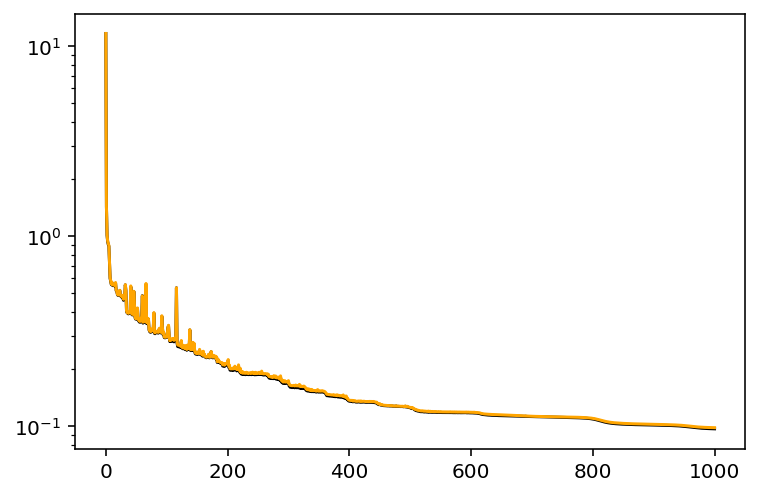

In [ ]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

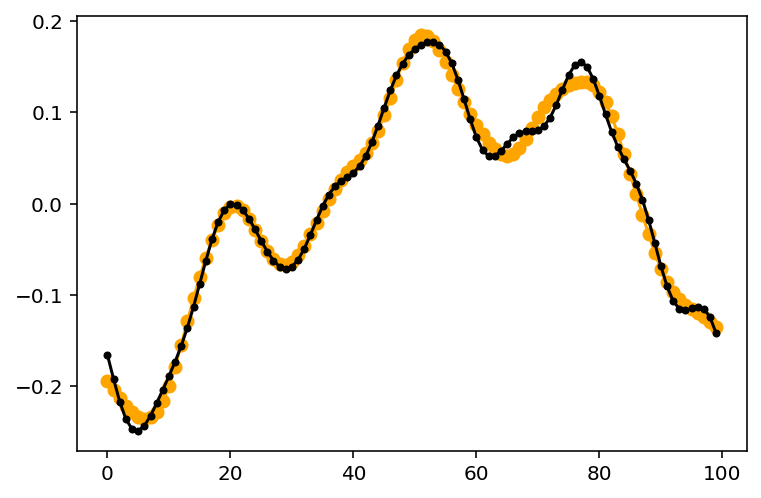

In [ ]:
N = 0
plt.plot(DeepONet.NN(params, train[0][N], x), "o-", color="orange")
plt.plot(train[1][N], ".-", color="black");

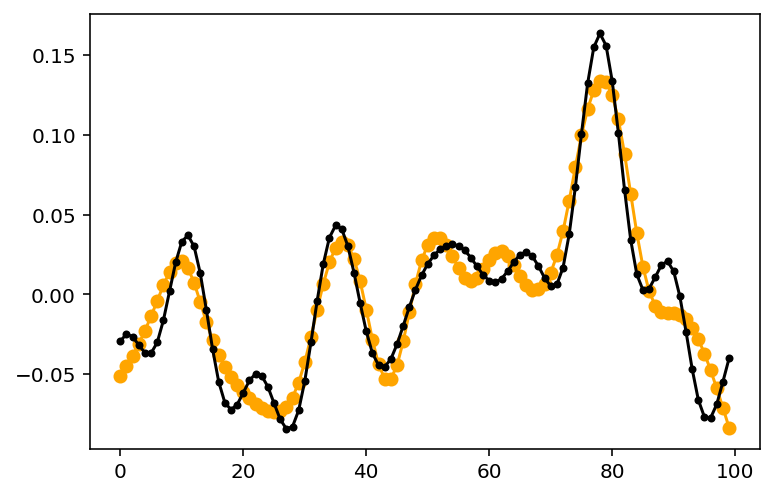

In [ ]:
N = 13
plt.plot(DeepONet.NN(params, test[0][N], x), "o-", color="orange")
plt.plot(test[1][N], ".-", color="black");

Mean relative test error 0.12610881551084943


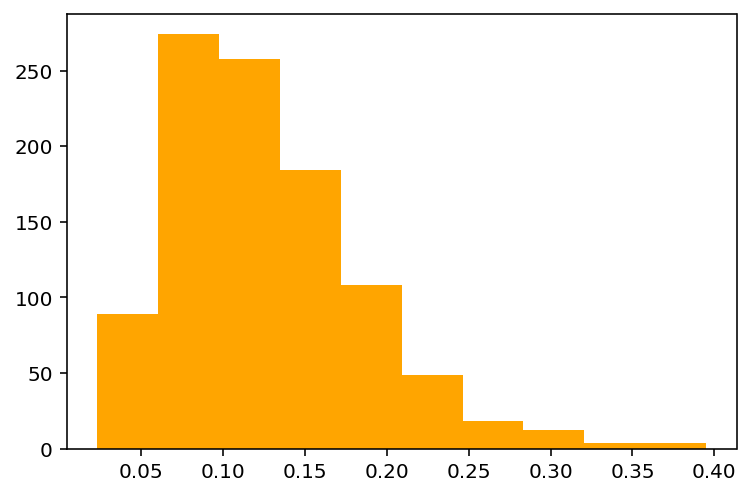

In [ ]:
predictions = DeepONet.batched_NN(params, test[0], x).reshape(1000, 100)
relative_errors = jnp.linalg.norm(predictions - test[1].reshape(1000, 100), axis=1) / jnp.linalg.norm(test[1].reshape(1000, 100), axis=1)
plt.hist(relative_errors, color="orange")
mean_relative_test_error = jnp.mean(relative_errors)
print("Mean relative test error", mean_relative_test_error);

# Training II

Initialize network

In [ ]:
c_sizes = [1, 50, 50, 50, 50]
x_sizes = [50, 50, 50, 50, 50]

params = DeepONet.init_network_params(x_sizes, c_sizes, random.PRNGKey(12))

Initialize optimizer

In [ ]:
sc = 0.01 #optax.exponential_decay(0.001, 5000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

Create dataset

In [ ]:
N_samples = 500
Data = Derivatives.Fourier_series(10, 50, 2*N_samples, key=random.PRNGKey(1729), sigma=2, periodic=True, return_coefficients=False)

x = utils.grid(50, periodic=True).reshape(-1, 1)
train = (Data[0][:250], Data[1][:250])
test = (Data[0][250:], Data[1][250:])

In [ ]:
loss = lambda params, a, b: DeepONet.loss(params, a, x, b)

In [ ]:
%timeit -o utils.update_params(params, train[0], train[1], optimizer, opt_state, loss);

The slowest run took 899.56 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 4.51 ms per loop


<TimeitResult : 1 loop, best of 5: 4.51 ms per loop>

In [ ]:
res = _
mean_t = sum(r/res.loops for r in res.all_runs) / len(res.all_runs)
N_epochs = 30000

minutes = N_epochs*mean_t/60

print("Optimization will take ", round(minutes, ndigits=2), " minutes")

Optimization will take  2.97  minutes


In [ ]:
train_loss = []
test_loss = []

test_loss.append(loss(params, test[0], test[1]))
train_loss.append(loss(params, train[0], train[1]))

print(train_loss[-1])
print(test_loss[-1])

0.11735282250412203
0.1278651181433957


In [ ]:
for i in range(N_epochs):
  # run in a single batch
  params, opt_state = utils.update_params(params, train[0], train[1], optimizer, opt_state, loss)
  if (i+1)%100 == 0:
    test_loss.append(loss(params, test[0], test[1]))
    train_loss.append(loss(params, train[0], train[1]))

In [ ]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

In [ ]:
N = 0
plt.plot(DeepONet.NN(params, train[0][N], x), "o-", color="orange")
plt.plot(train[1][N], ".-", color="black");

In [ ]:
N = 13
plt.plot(DeepONet.NN(params, test[0][N], x), "o-", color="orange")
plt.plot(test[1][N], ".-", color="black");

In [ ]:
predictions = DeepONet.batched_NN(params, test[0], x).reshape(750, 50)
relative_errors = jnp.linalg.norm(predictions - test[1].reshape(750, 50), axis=1) / jnp.linalg.norm(test[1].reshape(750, 50), axis=1)
plt.hist(relative_errors, color="orange")
mean_relative_test_error = jnp.mean(relative_errors)
print("Mean relative test error", mean_relative_test_error);

# 2D

In [ ]:
from architectures import DeepONet_2D as DeepONet

from datasets import KdV_exact
from functions import utils, Fourier, Chebyshev

# Write, load and count

In [ ]:
c_sizes = [1, 50, 50, 50, 100]
sizes_x = [50, 50, 50, 50, 10]
sizes_y = [1, 50, 50, 50, 10]

params = DeepONet.init_network_params(sizes_x, sizes_y, c_sizes, random.PRNGKey(12))

In [ ]:
DeepONet.count_params(params)

31451

In [ ]:
DeepONet.save_params(params, "deep_zebra", "DeepONet_run_134")
params_ = DeepONet.load_params("deep_zebra", "DeepONet_run_134")

In [ ]:
print("Same number of layers --", len(params) == len(params_))
print("====")

for i in range(len(params)):
  print("Layer " + str(i))
  for j in range(len(params[i])):
    print(jnp.all(params[i][j] == params_[i][j]))
  print("====")

Same number of layers -- True
====
Layer 0
True
True
True
True
True
====
Layer 1
True
True
True
True
True
====
Layer 2
True
True
True
True
True
====
Layer 3
True
True
True
True
True
====
Layer 4
True
====


# Training I

Initialize network

In [ ]:
c_sizes = [2, 100, 100, 100, 10000]
sizes_x = [100, 100, 100, 100, 100]
sizes_y = [1, 100, 100, 100, 100]

params = DeepONet.init_network_params(sizes_x, sizes_y, c_sizes, random.PRNGKey(12))

In [ ]:
DeepONet.count_params(params)

1140601

Initialize optimizer

In [ ]:
sc = 0.001 #optax.exponential_decay(0.001, 5000, 0.5)
optimizer = optax.adam(sc)
opt_state = optimizer.init(params)

Create dataset

In [ ]:
N_samples = 100
Data = KdV_exact.KdV_2D(100, 100, N_samples, key=random.PRNGKey(1729), periodic=True, return_coefficients=False)

x = utils.grid(100, periodic=True)
t = 0.0005 * (utils.grid(100, periodic=True) + 1) / 2
x, t = jnp.meshgrid(x, t, indexing="ij")
X = jnp.stack([x, t], -1)

train = (jnp.expand_dims(Data[0][:50, :, 0], -1), Data[1][:50])
test = (jnp.expand_dims(Data[0][50:, :, 0], -1), Data[1][50:])

# Predictions before training

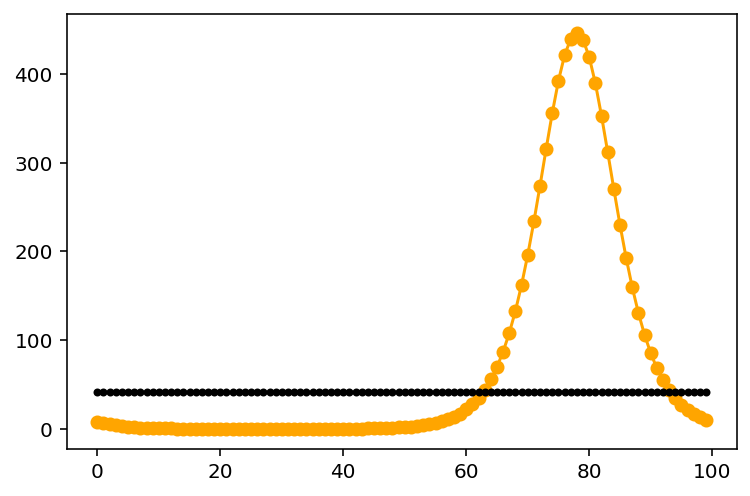

In [ ]:
N = 13
plt.plot(train[1][N][:, -1], "o-", color="orange")
plt.plot(DeepONet.NN(params, train[0][N], X)[:, 0], ".-", color="black");

In [ ]:
loss = lambda params, a, b: DeepONet.loss(params, a, X, b)

In [ ]:
%timeit -o utils.update_params(params, train[0], train[1], optimizer, opt_state, loss);

10 loops, best of 5: 175 ms per loop


<TimeitResult : 10 loops, best of 5: 175 ms per loop>

In [ ]:
res = _
mean_t = sum(r/res.loops for r in res.all_runs) / len(res.all_runs)
N_epochs = 1000

minutes = N_epochs*mean_t/60

print("Optimization will take ", round(minutes, ndigits=2), " minutes")

Optimization will take  2.92  minutes


In [ ]:
train_loss = []
test_loss = []

test_loss.append(loss(params, test[0], test[1]))
train_loss.append(loss(params, train[0], train[1]))

print(train_loss[-1])
print(test_loss[-1])

26204.993843097138
23189.1219093271


In [ ]:
for i in range(N_epochs):
  params, opt_state = utils.update_params(params, train[0], train[1], optimizer, opt_state, loss)
  if (i+1)%5 == 0:
    test_loss.append(loss(params, test[0], test[1]))
    train_loss.append(loss(params, train[0], train[1]))

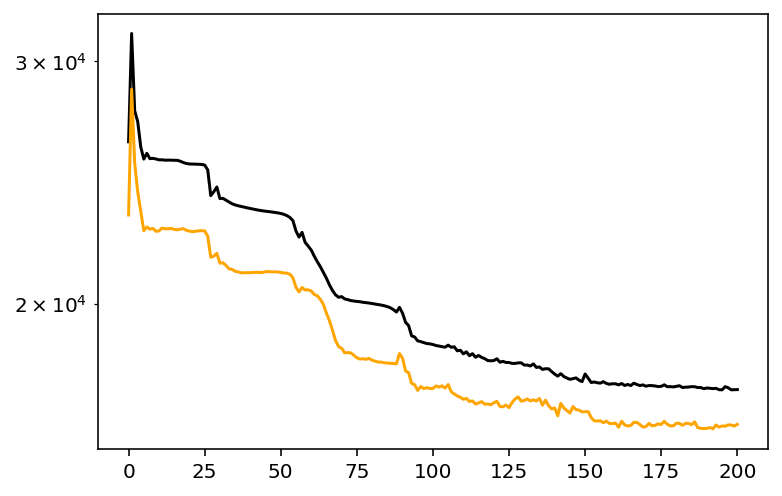

In [ ]:
plt.yscale("log")
plt.plot(train_loss, color="black")
plt.plot(test_loss, color="orange");

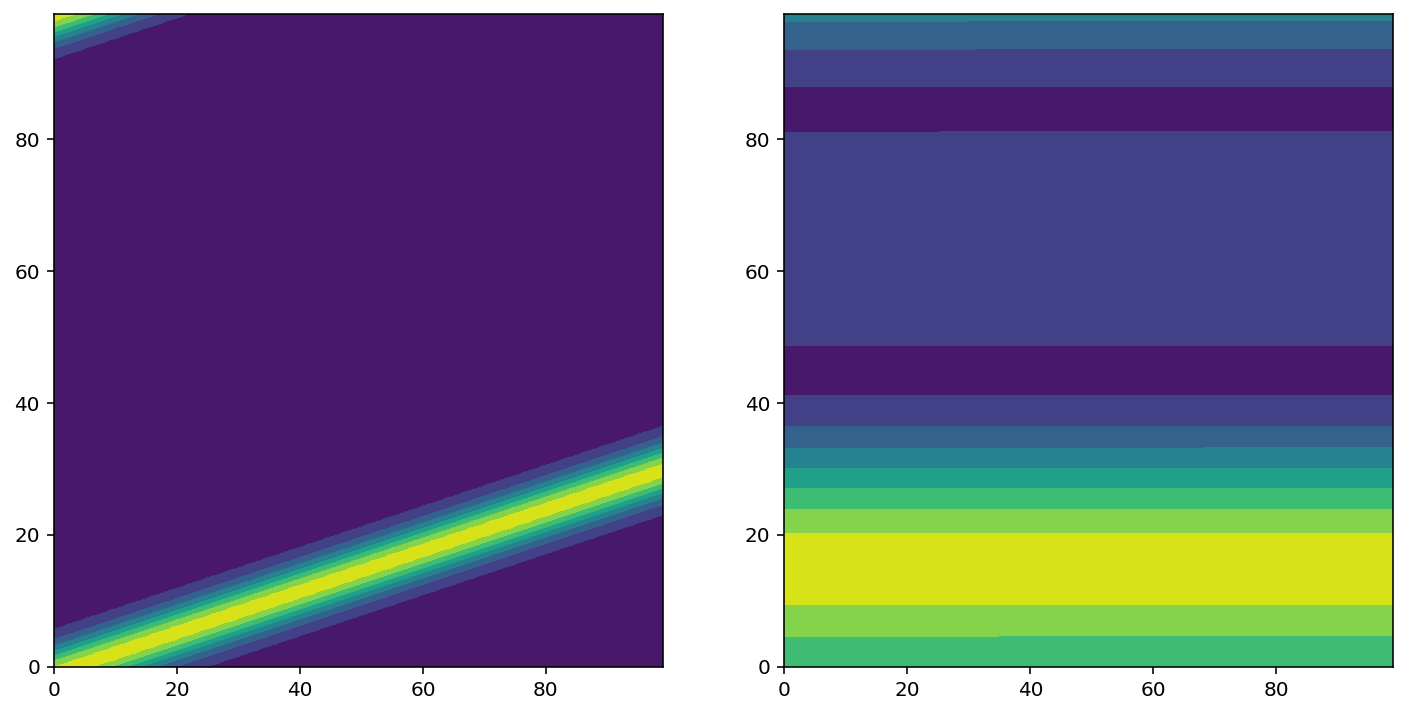

In [ ]:
N = 0

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].contourf(train[1][N])
ax[1].contourf(DeepONet.NN(params, train[0][N], X));

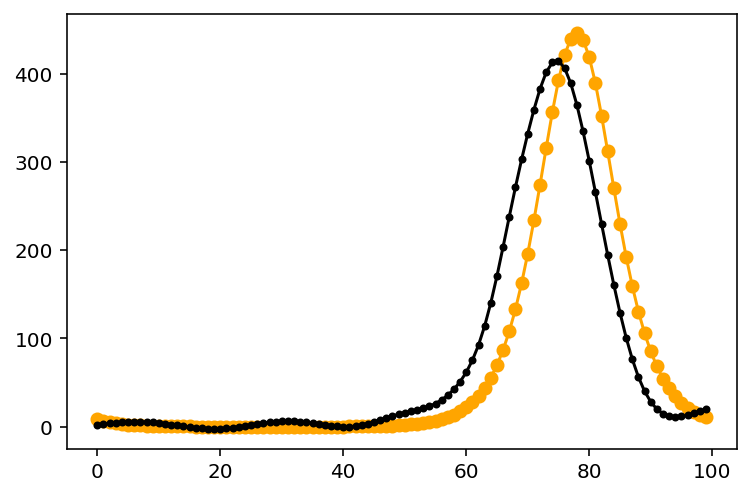

In [ ]:
N = 13
plt.plot(train[1][N][:, -1], "o-", color="orange")
plt.plot(DeepONet.NN(params, train[0][N], X)[:, -1], ".-", color="black");